In [2]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from datetime import datetime
from datetime import date
%matplotlib inline
plt.rc("figure", figsize=(8, 8))

Text(0.5, 0, 'Time Stamp')

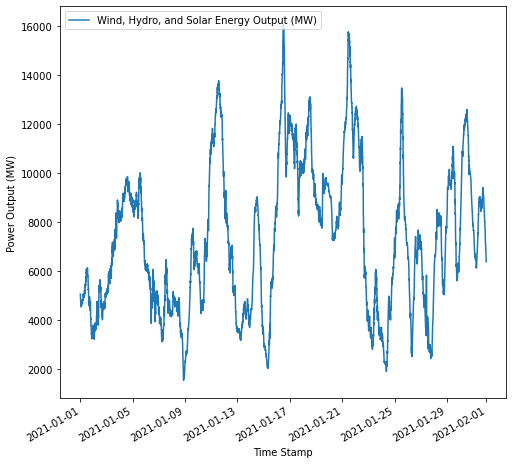

In [3]:
from cProfile import label


df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
#df.plot()
df = df.sum(axis = 1)
df['2021-1-01':'2021-1-31'].plot(label='Wind, Hydro, and Solar Energy Output (MW)')
plt.legend(loc="upper left")
plt.ylabel('Power Output (MW)')
plt.xlabel('Time Stamp')

In [4]:
i = df.max()
i

19753.0

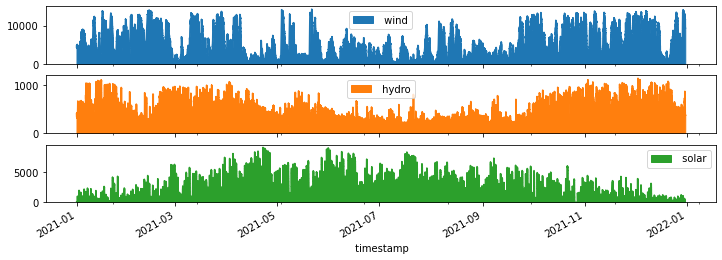

In [5]:
df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
axs = df.plot.area(figsize=(12, 4), subplots=True)

In [6]:
network = pypsa.Network()

In [7]:
network.snapshots = i = pd.date_range("2021-01-01 00:00", "2021-01-31 23:00", freq="0.08333333333333333333H")

network.snapshots


DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:05:00',
               '2021-01-01 00:10:00', '2021-01-01 00:15:00',
               '2021-01-01 00:20:00', '2021-01-01 00:25:00',
               '2021-01-01 00:30:00', '2021-01-01 00:35:00',
               '2021-01-01 00:40:00', '2021-01-01 00:45:00',
               ...
               '2021-01-31 22:15:00', '2021-01-31 22:20:00',
               '2021-01-31 22:25:00', '2021-01-31 22:30:00',
               '2021-01-31 22:35:00', '2021-01-31 22:40:00',
               '2021-01-31 22:45:00', '2021-01-31 22:50:00',
               '2021-01-31 22:55:00', '2021-01-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8917, freq='5T')

In [8]:
network.add('Bus',"London", v_nom=380)
network.add("Bus", "HydrogenStore", carrier="H2")

In [9]:
#Demand
network.add(
  "Load",
  name= 'LondonDemand',
  bus='London',
  p_set= [3000]*len(network.snapshots) #MW active power set point
)

In [10]:
df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
#df.plot()
df = df.sum(axis = 1)

network.add(
    'Generator',
    name= 'TotalGenerator',
    bus= 'London',
    p_nom= 19753,#MW nominal power
    p_max_pu= df["2021-01-01 00:00": "2021-01-31 23:24"].values / df["2021-01-01 00:00": "2021-01-31 23:24"].values.max(),
    #p_max_pu= df["2021-01-01 00:00": "2021-01-31 23:24"].values,
    #p_max_pu= , proportion of 
    capital_cost= 1600000, #currency/MWh
    efficiency=1,
    marginal_cost=95, #currency/MWh
    carrier='AC'
    )

#network.generators_t.p_set.plot()
#plt.tight_layout()

In [11]:



#Generation to storage, Electrolysers
network.add(
  "Link",
  "Electrolyser",
  bus0="London",
  bus1="HydrogenStore",
  capital_cost=350000, #currency/MWh
  p_nom_extendable=True, #Switch to allow capacity p_nom to be extended 
  efficiency=0.8,
)

#H2 to London, Fue Cells
network.add(
  "Link",
  "Fuel Cell",
  bus0="HydrogenStore",
  bus1="London",
  capital_cost=339000,
  p_nom_extendable=True,
  efficiency=0.58,
)

#Storage
network.add(
  "Store",
  "Hydrogen Storage",
  bus="HydrogenStore",
  capital_cost=11200,
  marginal_cost=25, #currency/MWh
  e_nom_extendable=True,
  e_cyclic=True, #True, then e_initial is ignored and the initial energy is set to the final energy for the group of snapshots in the OPF.
)


In [12]:
network.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3841092282.79235
  Upper bound: 3841092282.79235
  Number of objectives: 1
  Number of constraints: 80254
  Number of variables: 44589
  Number of nonzeros: 160507
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 55.303855895996094
# ----------------------------------------------------------
#   Solution Information
# ---

/home/jason/anaconda3/lib/python3.9/site-packages/pypsa/opf.py:1293: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat({c.name:


(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [13]:
network.objective / 10**9

3.8410922827923497

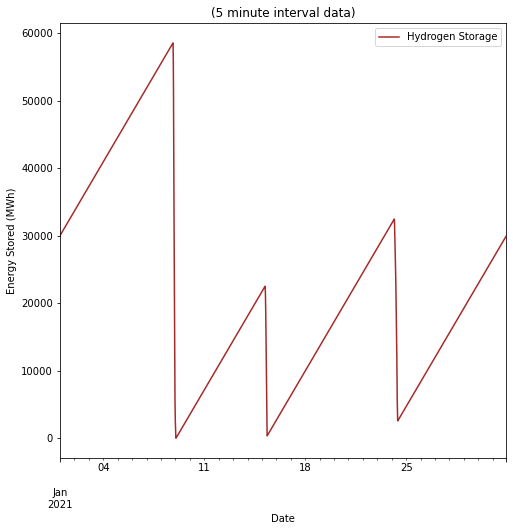

In [14]:
import matplotlib.pyplot as plt


network.stores_t.e.plot(color="brown")
plt.xlabel("Date")
plt.ylabel("Energy Stored (MWh)")
plt.title("(5 minute interval data)")
plt.legend()

In [15]:
network.stores_t.e


Store,Hydrogen Storage
snapshot,
2021-01-01 00:00:00,30017.634518
2021-01-01 00:05:00,30030.275690
2021-01-01 00:10:00,30042.916862
2021-01-01 00:15:00,30055.558033
2021-01-01 00:20:00,30068.199205
...,...
2021-01-31 22:40:00,29954.428659
2021-01-31 22:45:00,29967.069831
2021-01-31 22:50:00,29979.711003
